# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
import matplotlib.pyplot as plt

In [43]:
# Load .env enviroment variables, allow user to define path or use .env in current dir
env_path = Path('path/goes/here')
if os.path.exists(env_path):
    print (f'Using .env file in path {env_path}')
    load_dotenv(dotenv_path=env_path)
else:
    print ('Using local .env file')
    load_dotenv()

Using local .env file


In [3]:
# set constants for API keys, check type.
ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')
type(ALPACA_API_KEY), type(ALPACA_SECRET_KEY)

(str, str)

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
crypto_holdings = {
    'BTC':1.2,
    'ETH':5.3
}

In [5]:
# Crypto API URLs (maybe convert to AUD later on?)
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Function to get price 
def get_price(url):
    '''
    Takes alternative API url pointing to a ticker. Returns the price of the cryptocurrency in USD.

    json object structure: data (dict) > id (dict) > quotes (dict) > currency (dict) > price (key)

    url (str) = URL pointing to cryptocurrency ticker
    
    '''
    # access API and store as json
    response = requests.get(url).json()

    # get price, assuming the unique id is always the first element in the 'data' object
    price = list(response['data'].values())[0]['quotes']['USD']['price']
    return price


In [7]:
# Fetch current BTC price
btc_price = get_price(btc_url)

# Fetch current ETH price
eth_price = get_price(eth_url)

# Compute current value of my crypto
crypto_value = {
    'BTC_value' : crypto_holdings['BTC']*btc_price,
    'ETH_value' : crypto_holdings['ETH']*eth_price
}
# Print current crypto wallet balance
print(f"The current value of your {crypto_holdings['BTC']} BTC is ${crypto_value['BTC_value']:0.2f} USD")
print(f"The current value of your {crypto_holdings['ETH']} ETH is ${crypto_value['ETH_value']:0.2f} USD")

The current value of your 1.2 BTC is $48880.80 USD
The current value of your 5.3 ETH is $15060.27 USD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
# Set current amount of shares
share_folio = {
    'AGG' : 200,
    'SPY' : 50
}

In [9]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2")

In [11]:
# create function for api call, due to the get_barset function being depreciated, get_bars was used.
# this function returns data in a different form so additional data wrangling was nessecary.
def ticker_data (ticker, start = 1500):
    '''
    Uses the alpaca.get_bars function to obtain historical data about a stock ticker,

    slices API response and returns a Dataframe with datetime index.

    ticker (str) = stock ticker of interest

    start (int) =  neumerical value describing amount of historical data to collect (weekends/public holidays included).
    '''

    # Use yesterday because open markets can cause the api to return an error when requesting daily data.
    # use time local to the origin of the data (NY timezone).
    end_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1)).isoformat()

    # Set start date (default = 1501, approx 1000 trading days)
    start_date = (pd.Timestamp("today", tz="America/New_York") - pd.DateOffset(1+start)).isoformat()

    # Call API, pass in ticker argument, set timeframe to Day and set time period.
    data = alpaca.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df

    # slice columns
    data = data.drop(['trade_count', 'vwap', 'volume'], axis='columns')

    return data

In [12]:
# Because the later section uses historical data, get and store 5 years of data (assuming exactly 365 days/year)
five_years = 365*5

# call function for each ticker
spy = ticker_data('SPY', five_years)
agg = ticker_data('AGG', five_years)

# concatenate the ticker data and set keys for multi-indexing along columns
stock_data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')

# drop na, sort data.
stocks = stock_data.dropna().sort_index(ascending=True)

# Preview DataFrame
stock_data


SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760  107.93  108.270   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-21 04:00:00+00:00  107.9300  108.27  
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1259 rows x 8 columns]

In [13]:
# access the last element of the data for portfolio calaulcations
agg_close = stocks['AGG', 'close'][-1]
spy_close = stocks['SPY', 'close'][-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close}")
print(f"Current SPY closing price: ${spy_close}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [14]:
# Compute the current value of shares
share_value = {
    'AGG_value' : share_folio['AGG']*agg_close,
    'SPY_value' : share_folio['SPY']*spy_close
}

# Print current value of shares
print(f"The current value of your {share_folio['SPY']} SPY shares is ${share_value['SPY_value']:0.2f}")
print(f"The current value of your {share_folio['AGG']} AGG shares is ${share_value['AGG_value']:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = sum(crypto_value.values())
shares = sum(share_value.values())

# Create savings DataFrame, pass in data, transpose and rename column.
df_savings = pd.DataFrame({'crypto':[crypto], 'shares':[shares]}).T.rename(columns={0:'amount'})

# Display savings DataFrame
df_savings

,amount
crypto,63941.068
shares,43846.000


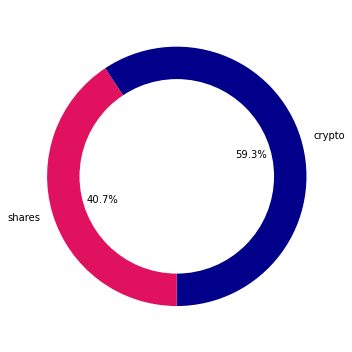

In [16]:
# Plot savings pie chart (maybe use this section to experiment, snippets of code used from link below)
# https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

# inputs
labels=df_savings.index.tolist()
values=df_savings['amount'].tolist() 
fig1, ax1 = plt.subplots(figsize=(5,5))
colors = ['#00008B','#E0115F']

# pie chart
ax1.pie(values, colors=colors, labels=labels, autopct='%1.1f%%', startangle = 270)

# draw inner white circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# format and show plot
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [17]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health
if savings > emergency_fund:
    print (f'Congratulations, your total savings of {savings:0.2f} should cover you in an emergency.')
elif savings == emergency_fund:
    print (f'Congratulations, you have reached your goal of {savings:0.2f} for an emergency fund!')
else:
    print (f'Your emergency fund is {(emergency_fund-savings):0.2f} away from your goal of {emergency_fund:0.2f}. Keep going!')

Congratulations, your total savings of 107787.07 should cover you in an emergency.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [18]:
#confirm the data is still in the form that is needed for MC simulations
stock_data

SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760  107.93  108.270   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-21 04:00:00+00:00  107.9300  108.27  
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1259 rows x 8 columns]

In [19]:
# Set weights for the portfolio (ensure that the order of the dict is the same as the order of the dataset)
weights = {
    'SPY':0.6,
    'AGG':0.4
}

# Configure a Monte Carlo simulation to forecast 30 years cumulative returns
# initilize monte carlo simulation. Forecasted trading days is 30 years (252 * 30)
mc_sim = MCSimulation(
    portfolio_data = stock_data,
    weights=list(weights.values()),
    num_simulation=500,
    num_trading_days=252*30
    )

In [20]:
# Print the simulation input data, verify that MCForecastTools has calculated daily return
mc_sim.portfolio_data

SPY                                        \
                              open    high     low    close daily_return   
timestamp                                                                  
2017-03-21 04:00:00+00:00  237.490  237.61  233.58  233.760          NaN   
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250     0.002096   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940    -0.001323   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880    -0.000256   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575    -0.001304   
...                            ...     ...     ...      ...          ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000    -0.007308   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170     0.021990   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620     0.022174   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070     0.012511   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520     0.007822   

                              AGG                                          
                             open     high       low   close daily_return  
timestamp                                                                  
2017-03-21 04:00:00+00:00  107.93  108.270  107.9300  108.27          NaN  
2017-03-22 04:00:00+00:00  108.44  108.540  108.3600  108.42     0.001385  
2017-03-23 04:00:00+00:00  108.44  108.510  108.2635  108.45     0.000277  
2017-03-24 04:00:00+00:00  108.35  108.510  108.3100  108.36    -0.000830  
2017-03-27 04:00:00+00:00  108.65  108.710  108.5345  108.62     0.002399  
...                           ...      ...       ...     ...          ...  
2022-03-14 04:00:00+00:00  107.78  107.816  107.3600  107.36    -0.009685  
2022-03-15 04:00:00+00:00  107.83  107.920  107.4300  107.60     0.002235  
2022-03-16 04:00:00+00:00  107.63  107.730  107.0032  107.68     0.000743  
2022-03-17 04:00:00+00:00  107.87  108.060  107.7300  107.86     0.001672  
2022-03-18 04:00:00+00:00  107.95  108.140  107.9203  108.10     0.002225  

[1259 rows x 10 columns]

In [21]:
# Run a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002876,1.001549,1.005153,1.003843,0.998737,0.993271,1.005385,1.002017,0.996802,1.004005,...,1.003565,0.998675,0.991903,1.011297,1.004866,0.997835,1.005944,1.007541,0.999127,1.003882
2,0.997586,1.000682,1.014018,1.002041,0.987656,0.998005,1.006383,0.996594,0.997008,1.001238,...,1.002898,0.997280,1.009113,1.014640,0.993095,0.996690,1.011898,0.996933,1.003316,1.007811
3,1.007247,0.995383,1.017360,1.002394,0.993273,0.995359,0.997791,0.995943,1.000439,1.006468,...,1.003839,0.992448,1.001844,1.027847,1.002430,1.009757,1.002587,1.003277,0.990472,1.008156
4,1.005337,0.997140,1.022010,0.995642,0.986331,0.991952,1.012053,0.997048,1.015618,1.005817,...,1.007157,0.994382,0.993162,1.033742,1.009110,1.011265,0.998411,1.011289,0.996802,0.997634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,18.343204,12.088357,16.440304,33.499043,14.283162,23.016602,8.553149,28.924677,20.157795,6.646594,...,19.393773,12.706670,15.518028,3.394013,19.860890,9.908822,15.265690,7.582205,2.338152,13.036892
7557,18.340639,11.982677,16.685857,33.980484,14.167069,23.122671,8.606002,28.554996,20.168573,6.716877,...,19.366135,12.763857,15.620025,3.400493,19.748239,9.825544,15.094184,7.503417,2.337217,12.989094
7558,18.116139,11.924357,16.735641,33.945431,14.219449,22.914031,8.658840,28.783538,20.220783,6.679995,...,19.306929,12.788740,15.670240,3.396885,19.497040,9.760055,15.027564,7.566239,2.312280,13.004390
7559,18.199405,11.941761,16.927420,34.088317,14.168093,23.154361,8.643775,28.580472,20.392046,6.716113,...,19.459006,12.859450,15.489536,3.399107,19.454582,9.790659,15.006030,7.561089,2.288180,13.106757


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

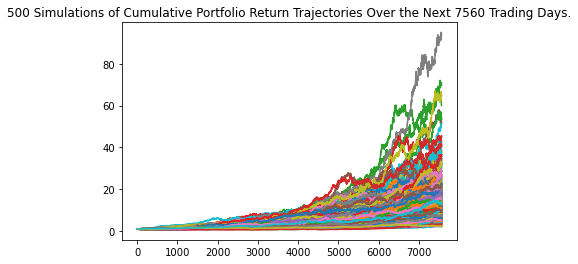

In [22]:
# Plot simulation outcomes
mc_sim.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

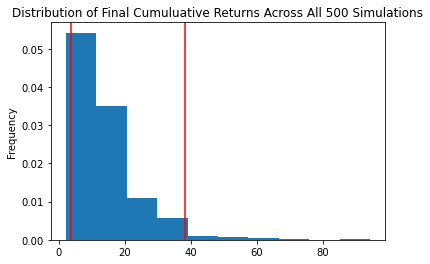

In [23]:
# Plot probability distribution and confidence intervals
mc_sim.plot_distribution()

### Retirement Analysis

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
summary = mc_sim.summarize_cumulative_return()

# Print summary statistics
summary

count           500.000000
mean             14.233173
std              10.111270
min               2.124243
25%               7.961828
50%              11.346157
75%              17.790845
max              94.279087
95% CI Lower      3.549538
95% CI Upper     38.157397
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [25]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of $20,000 investment.
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $70990.76 and $763147.95


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [26]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $106486.15 and $1144721.92


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [27]:
# configure a more agressive portfolio for a 5 year strategy
weights_5 = {
    'SPY':0.8,
    'AGG':0.2
}

In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5 = MCSimulation(portfolio_data = stock_data, weights=list(weights_5.values()), num_simulation=500, num_trading_days=252*5)

In [29]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004718,1.000108,1.001449,1.002772,1.011317,1.004624,0.995621,1.000434,1.003470,1.003515,...,0.978821,1.017521,1.008864,1.005936,0.988144,1.002918,1.014831,0.993309,0.987053,1.018921
2,1.001457,0.983867,1.005295,0.999079,1.008416,1.023879,0.992753,1.009569,1.023018,0.987968,...,0.978285,0.996230,1.024899,1.005932,0.983051,0.993489,1.029128,0.990880,0.993409,1.005048
3,0.996667,0.988183,0.991711,1.011182,1.005031,1.006441,0.982487,1.019978,1.024767,0.970273,...,0.973978,1.001625,1.033115,1.011783,0.980508,0.993747,1.015949,0.981078,0.995016,1.011321
4,0.997401,0.994506,0.983277,0.999502,0.992203,1.019262,0.973264,1.011929,1.017262,0.976750,...,0.976877,1.014859,1.021815,1.012790,0.967832,1.004154,1.017704,0.981524,1.003336,1.007577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.186650,1.393784,1.445452,1.708402,1.825973,1.549567,1.383844,1.286541,2.286842,1.113013,...,1.234765,3.089457,1.814772,1.944856,1.500207,2.716626,1.693220,1.960824,1.797967,1.672846
1257,3.159945,1.381281,1.447312,1.709047,1.844119,1.529490,1.411295,1.306878,2.271008,1.126434,...,1.239213,3.131926,1.817112,1.970806,1.496155,2.671522,1.707362,1.984514,1.827780,1.689962
1258,3.204667,1.354261,1.446918,1.698036,1.856182,1.523630,1.390580,1.306695,2.298617,1.109174,...,1.241630,3.149568,1.779545,1.945494,1.484754,2.637113,1.686326,1.997308,1.839771,1.677541
1259,3.219251,1.335078,1.436525,1.709374,1.869157,1.543003,1.380817,1.325984,2.329351,1.108035,...,1.257762,3.107636,1.789161,1.946951,1.460258,2.654565,1.711932,1.975574,1.850611,1.693532


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

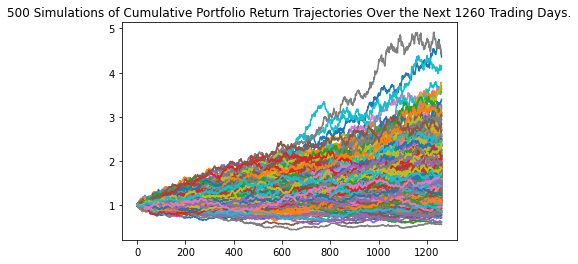

In [30]:
# Plot simulation outcomes
mc_sim_5.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

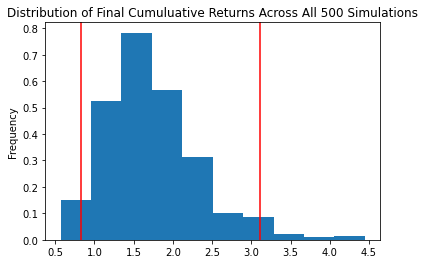

In [31]:
# Plot probability distribution and confidence intervals
mc_sim_5.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5 = mc_sim_5.summarize_cumulative_return()

# Print summary statistics
summary_5

count           500.000000
mean              1.735461
std               0.601072
min               0.566942
25%               1.326578
50%               1.660229
75%               2.049459
max               4.447549
95% CI Lower      0.834028
95% CI Upper      3.103942
Name: 1260, dtype: float64

In [36]:
# Set initial investment
initial_investment_5 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
lower_5 = initial_investment_5*summary_5['95% CI Lower']
upper_5 = initial_investment_5*summary_5['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${lower_5:0.2f} and ${upper_5:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 5 years will end within in the range of $50041.66 and $186236.53


### Ten Years Retirement Option

In [37]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns using original 60/40 weigths
mc_sim_10 = MCSimulation(portfolio_data = stock_data, weights=list(weights.values()), num_simulation=500, num_trading_days=252*10)

In [38]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Financial-Monte-Carlo/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009307,1.016171,1.007546,1.003177,0.997585,1.007622,1.009640,1.008440,0.975656,0.992937,...,1.009051,0.991706,1.001872,0.995867,1.020287,1.001428,1.012383,1.000193,0.995157,1.015001
2,1.003824,1.020429,0.999058,1.022493,0.995411,1.027179,1.011174,1.000339,0.972221,1.007085,...,1.023126,0.992382,0.992092,0.999280,1.017554,0.990830,1.025119,1.004687,0.985450,1.030207
3,0.999078,1.005424,0.995563,1.033321,0.991290,1.030871,1.011278,1.004286,0.967714,0.995180,...,1.020941,0.994323,0.988743,1.002367,1.033109,0.984219,1.016053,0.998304,0.988900,1.030432
4,1.003402,1.010846,0.996908,1.021417,0.982136,1.021381,1.006343,1.007546,0.965748,0.991220,...,1.025105,1.001196,0.993722,0.991729,1.053155,0.977542,1.013441,1.000030,0.998785,1.042310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.954305,1.612706,1.431118,1.552874,1.578848,2.874890,2.037613,2.621911,0.900258,2.037808,...,3.115202,2.099451,2.921606,5.637327,2.457253,2.574164,2.334303,1.907855,2.383936,1.771142
2517,2.966876,1.615189,1.411216,1.552267,1.564171,2.849199,2.058935,2.587713,0.885558,2.035296,...,3.087458,2.134980,2.941852,5.674918,2.474417,2.562830,2.320438,1.894098,2.382501,1.757071
2518,2.945194,1.614491,1.398709,1.544775,1.553472,2.838701,2.062786,2.569987,0.882093,2.046279,...,3.097870,2.152401,2.928591,5.716377,2.490541,2.573660,2.329286,1.896795,2.369272,1.766930
2519,2.971158,1.622607,1.399086,1.535004,1.561456,2.819792,2.081795,2.557165,0.890020,2.049796,...,3.094805,2.174187,2.950828,5.778727,2.481137,2.558150,2.321843,1.897957,2.375616,1.777153


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

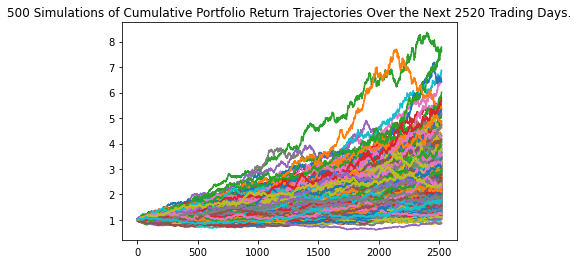

In [39]:
# Plot simulation outcomes
mc_sim_10.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

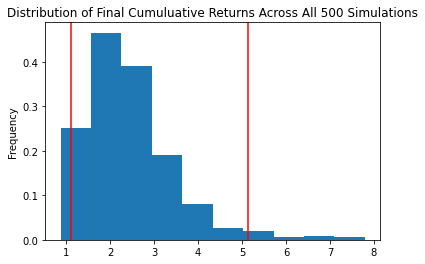

In [40]:
# Plot probability distribution and confidence intervals
mc_sim_10.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10 = mc_sim_10.summarize_cumulative_return()

# Print summary statistics
summary_10

count           500.000000
mean              2.437643
std               1.014876
min               0.867798
25%               1.757824
50%               2.254750
75%               2.889695
max               7.791603
95% CI Lower      1.114763
95% CI Upper      5.126345
Name: 2520, dtype: float64

In [42]:
# Set initial investment
initial_investment_10 = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
lower_10 = initial_investment_10*summary_10['95% CI Lower']
upper_10 = initial_investment_10*summary_10['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${lower_10:0.2f} and ${upper_10:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $66885.79 and $307580.72
